In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, InterpolationMode, ToTensor, ToPILImage
from torchvision.utils import save_image, make_grid
import os
from copy import deepcopy
import numpy as np

In [3]:
from super_image_resolution.utils import load_torch_module, dump, make_dirs, load, split, find_files
from super_image_resolution.datasets import CustomDataset
from super_image_resolution.training.pcgan import PCGAN

# Splitting Whole Slide Images (WSIs) into train, validation and test set

In [4]:
SEED = 40
SPLIT_RATIO = [.8, .15, .05]
FROM_SIZE = 128
TO_SIZE = 256
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 48
train_wsi, val_wsi, test_wsi = split(
    path="/scratch/mittal.nit/Post-NAT-BRCA/samples256x256_v2/", 
    ratios=SPLIT_RATIO, 
    seed=SEED)
print(f"Number of WSI in train: {len(train_wsi)}, val: {len(val_wsi)}, test: {len(test_wsi)}")

Number of WSI in train: 55, val: 10, test: 4


In [5]:
train_patches = [patch for wsi in train_wsi for patch in find_files(wsi, ext="png")]
val_patches = [patch for wsi in val_wsi for patch in find_files(wsi, ext="png")]
test_patches = [patch for wsi in test_wsi for patch in find_files(wsi, ext="png")]
print(f"Number of patches in train: {len(train_patches)}, val: {len(val_patches)}, test: {len(test_patches)}")

Number of patches in train: 11000, val: 2000, test: 800


## Defining input and output transformations

In [6]:
in_transforms = Compose([
    Resize(size=FROM_SIZE, interpolation=InterpolationMode.BICUBIC),
    Resize(size=TO_SIZE, interpolation=InterpolationMode.BICUBIC), 
    ToTensor()
])

out_transforms = Compose([
    ToTensor()
])

## Defining PyTorch based dataset and dataloader

In [7]:
train_dataset = CustomDataset(
    paths=train_patches,
    in_transforms=in_transforms,
    out_transforms=out_transforms)


val_dataset = CustomDataset(
    paths=val_patches,
    in_transforms=in_transforms,
    out_transforms=out_transforms)

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=True)

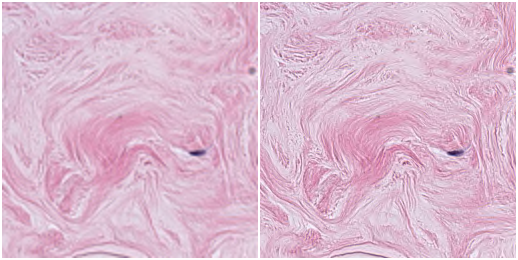

In [8]:
fps, X, Y = next(iter(train_loader))
ToPILImage()(make_grid(tensor=[X[0], Y[0]], pad_value=1.),)

## Initiating PCGAN Trainer

In [9]:
pcgan = PCGAN(
    in_channels=3, 
    out_channels=3, 
    gen_norm="batchnorm", 
    gen_act="lrelu", 
    gen_final_act="tanh", 
    dis_norm="batchnorm",
    dis_act="lrelu", 
    dis_final_act="relu", 
    dis_depth=3, 
    dis_kernel_size=4,
    dis_stride=2,
    dis_padding=1, 
    experiment_version=4,
    experiment_save_path=os.path.join(
        "/home/mittal.nit/projects/super_image_resolution/assets",
        f"pcgan_wsi_patches_{FROM_SIZE}to{TO_SIZE}"), 
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), 
    dis_step_interval=3,
    gen_loss_weight=100., 
    dis_loss_weight=1.,
    gen_lr=1e-4,
    dis_lr=1e-4,
    val_step_interval=200,  
    val_output_save_interval=10,
    max_num_val_output_save=2, 
    metrics_save_interval=50,
    verbose=False,
    seed=SEED,
    split_ratio=SPLIT_RATIO,
    from_size=FROM_SIZE,
    to_size=TO_SIZE, 
    train_batch_size=TRAIN_BATCH_SIZE,
    val_batch_size=VAL_BATCH_SIZE)

In [ ]:
pcgan.run(
    train_loader,
    val_loader, 
    num_epochs=100)

Epoch: 54/100, step: 36800/68800, validating: 7/42:  53%|█████▎    | 53/100 [7:27:37<6:41:57, 513.15s/it]  